*   The present script was developed and used on Google Colab. The purpose of the script is to allow the user to use the model described in our paper "DamageMap: A post-wildfire damaged buildings classifier", and visualize its' performance. The model will output "0" for an undamaged building, and "1" for a damaged building.

When using the model to classify the images of a chosen dataset, the dataset should consist of separate images of building roofs. The user should prepare the dataset in the following way:

*   If the true labels of the images are not known, then all of the images should be contained in one folder. 

*   If the true labels of the dataset are known then the dataset should be prepared in the following way. Create a folder that contains 2 subfolders. The first subfolder (in alphabetical order) should contain the images of the undamaged buildings, because they will automatically get the label "0" (and we want it to match the prediction of our model for undamaged buildings). The second subfolder (in alphabetical order) should contain the images of damaged buildings.

The following cell allows Google Colab to get access to the files of your Google Drive.

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

%cd drive/My\ Drive

Mounted at /content/drive
/content/drive/My Drive


Importing *necessary* libraries.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import sampler, RandomSampler, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from PIL import Image, ImageOps
import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
from sklearn.metrics import confusion_matrix
import time

import seaborn as sns
from __future__ import print_function 
from __future__ import division
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.6.0+cu101
Torchvision Version:  0.7.0+cu101


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


If a GPU is available then the following cell will allow our model to use it, to classify faster.

In [ ]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


print('using device:', device)

using device: cpu


Load the model that will be used for classification

In [ ]:
%%capture
MODEL_PATH = "damaged_structures_detector/checkpoints/Resnet_model_trained_on_xbd.pth"
model = torch.load(MODEL_PATH, map_location=device)
model.to(device)
model.eval()

Load and prepare the dataset that the model will classify.

In [ ]:
FOLDERNAME = 'damaged_structures_detector/xbd_images'  # Path to the masterfolder. In our case this master folder contains subfolders corresponding to train, validation, and test set

data_transform = transforms.Compose([ # specifying the transformations that we will apply to the new dataset before classifying its' images
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4597, 0.4655, 0.3800],   # Normalize by the mean and std of Xbd dataset
                             std=[0.1425, 0.1265, 0.1287])
    ])

train_dataset = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'train'),transform = data_transform) # load training set
val_dataset = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'val'),transform = data_transform)     # load validation set
test_dataset = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'test'),transform = data_transform)   # load test set

# repeating the previous 3 lines, because sometimes Google Colab fails to load datasets in first attempt
train_dataset = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'train'),transform = data_transform)
val_dataset = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'val'),transform = data_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'test'),transform = data_transform)

# Number of training examples
NUM_TRAIN = len(train_dataset)

# Number of Validation examples
NUM_VAL = len(val_dataset)

# Number of Test Examples
NUM_TEST = len(test_dataset)

# Batch Size for Training (limited by GPU or CPU memory)
BATCH_SIZE = 128


# The following lines shuffle the 3 datasets (train-val-test) using Random Samplers
train_indices = list(range(NUM_TRAIN))
np.random.shuffle(train_indices)

val_indices = list(range(NUM_VAL))
np.random.shuffle(val_indices)

test_indices = list(range(NUM_TEST))
np.random.shuffle(test_indices)

train_idx, val_idx, test_idx = train_indices, val_indices, test_indices

train_sampler = SubsetRandomSampler(train_idx)
val_sampler   = SubsetRandomSampler(val_idx)
test_sampler  = SubsetRandomSampler(test_idx)


## The following lines prepare the Pytorch dataloaders that will later be used for classification and performance visualization, and add all of them in a dictionary for convenience

loader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers = 16)
                          
loader_val = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler, num_workers = 16)

loader_test = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=test_sampler, num_workers = 16)



dataloaders_dict = {}
dataloaders_dict.update( {'train' : loader_train} )
dataloaders_dict.update( {'val' : loader_val} )
dataloaders_dict.update( {'test' : loader_test} )

The following defines two different data transformations.



1.   The first transformation is only resizing and cropping the image. We use this transformation to see the original image (in the size of the model's input).
2.   The second transformation contains a resize and cropping, followed by a normalization. We use this transformation to feed images to the model for classification. As described in our paper the images fed to the model should be normalized by the mean and std of the dataset that was used during training.



In [ ]:
MEAN = [0.4597, 0.4655, 0.3800] # Mean value of Xbd dataset images (used for training of DamageMap). For models trained on Camp and Carr fire datasets the following mean should be used: [0.3662, 0.3452, 0.3384]
STD  = [0.1425, 0.1265, 0.1287] # Standard deviation value of Xbd dataset images (used for training of DamageMap). For models trained on Camp and Carr fire datasets the following std should be used: [0.1552, 0.1500, 0.1475]

test_transforms_print = transforms.Compose([transforms.Resize(224),    # transformation for printing
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()
                                     ])

test_transforms_predict = transforms.Compose([transforms.ToPILImage(),  # transformation for predicting
                                      transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=MEAN,
                                                            std=STD)
                                     ])

The following function returns a number (specified by variable "num") of random images from a specified dataset.

In [1]:
folder = 'damaged_structures_detector/xbd_images/val' # folder containing the dataset from which random images will be drawn

def get_random_images(num):
    data = datasets.ImageFolder(root=os.path.join(folder), transform = test_transforms_print)
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels, data.classes

The following function creates the saliency maps, presented and discussed in our paper.

In [ ]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    
    # Make input tensor require gradient
    X.requires_grad_()
    
    saliency = None

    #forward pass
    scores = model(X)
    scores = (scores.gather(1, y.view(-1, 1)).squeeze())
    
    #backward pass
    scores.backward(torch.FloatTensor([1.0]*scores.shape[0]))
    
    #saliency
    saliency, _ = torch.max(X.grad.data.abs(), dim=1)

    return saliency

The following set picks a small number of random images from a specified dataset (using the function described 2 cells above), computes the saliency maps for these images using the model loaded above, and finally uses the model to predict the labels of the images.

In [ ]:
# Import Some Random Images
to_pil = transforms.ToPILImage()
images, labels, classes = get_random_images(6)
gpu_images = images.clone()

for i in range(gpu_images.shape[0]):
    gpu_images[i,:,:,:] = test_transforms_predict(gpu_images[i,:,:,:])

gpu_images = gpu_images.to(device)

# Compute Saliency Maps
saliency = compute_saliency_maps(gpu_images, labels, model)

# Predict Their labels
outputs = model(gpu_images)
_, preds = torch.max(outputs, 1)
preds = preds.data.cpu().numpy()

labels = labels.cpu().numpy()

The following cell prints the original images, their true labels, and the corresponding saliency maps.

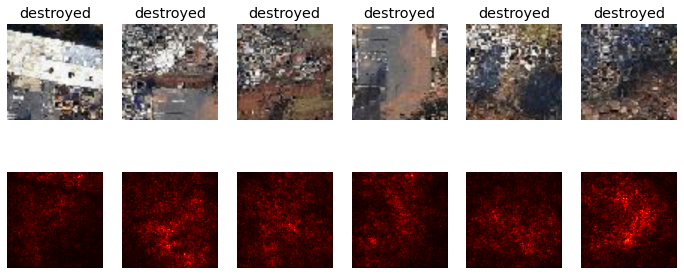

In [ ]:
N = len(images)
for i in range(N):
    image = to_pil(images[i])
    plt.subplot(2, N, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.rc('font', size=12)
    if labels[i] == 0:
      plt.title('not destroyed')     
    else:
      plt.title('destroyed')
    plt.subplot(2, N, N + i + 1)
    plt.imshow(saliency[i], cmap=plt.cm.hot)
    plt.axis('off')
    plt.gcf().set_size_inches(12, 5)
plt.show()

The following cell is printing the same images as before, this time together with the model's prediction (followed by "True" if prediction is correct, "False" otherwise).

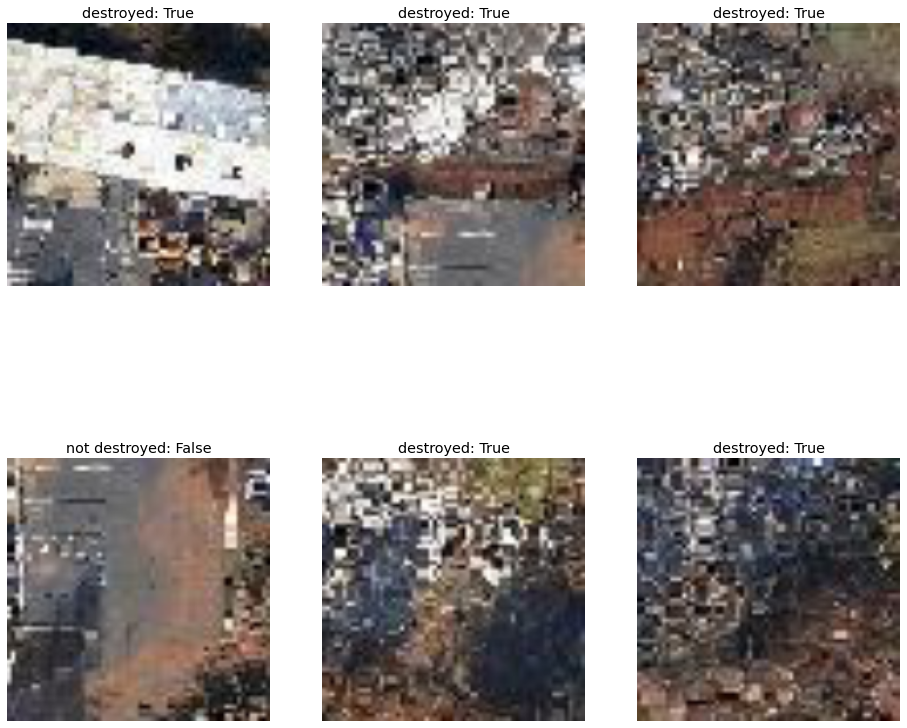

In [ ]:
# Plot the results
fig=plt.figure(figsize=(16, 16))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = preds[ii]
    cor_class = classes[index]
    sub = fig.add_subplot(2, len(images)/2, ii+1)
    fig.subplots_adjust(hspace=0.0, wspace=0.2)
    res = int(labels[ii]) == index
    if cor_class == classes[0]:
      sub.set_title(str(cor_class.split('_')[1]) + " " + cor_class.split('_')[2] + ": " + str(res))
    else:
      sub.set_title(str(cor_class.split('_')[1]) + ": " + str(res))
    plt.axis('off')
    plt.imshow(image)
    plt.savefig('damaged_structures_detector/Model Predictions.png')
plt.show()

Calculate Confusion Matrix, Precision, Recall, and F1 Score

In [ ]:
# Calculate and print Confusion Matrix
CF = np.zeros((2,2))
i = 0

for examples, true_labels in dataloaders_dict['test']:
  examples = examples.to(device)
  i += 1
  print('batch', i, '/', int(np.ceil(NUM_VAL / BATCH_SIZE)))

  with torch.no_grad():
    outputs = model(examples)
    _, preds = torch.max(outputs, 1)

  CF += confusion_matrix(true_labels.numpy(), preds.data.cpu().numpy())


print(CF)

batch 1 / 88
batch 2 / 88
batch 3 / 88
batch 4 / 88
batch 5 / 88
batch 6 / 88
batch 7 / 88
batch 8 / 88
batch 9 / 88
batch 10 / 88
batch 11 / 88
batch 12 / 88
batch 13 / 88
batch 14 / 88
batch 15 / 88
batch 16 / 88
batch 17 / 88
batch 18 / 88
batch 19 / 88
batch 20 / 88
batch 21 / 88
batch 22 / 88
batch 23 / 88
batch 24 / 88
batch 25 / 88
batch 26 / 88
batch 27 / 88
batch 28 / 88
batch 29 / 88
batch 30 / 88
batch 31 / 88
batch 32 / 88
batch 33 / 88
batch 34 / 88
batch 35 / 88
batch 36 / 88
batch 37 / 88
batch 38 / 88
batch 39 / 88
batch 40 / 88
batch 41 / 88
batch 42 / 88
batch 43 / 88
batch 44 / 88
batch 45 / 88
batch 46 / 88
batch 47 / 88
batch 48 / 88
batch 49 / 88
batch 50 / 88
batch 51 / 88
[[5035.   61.]
 [  62. 1330.]]
total time:  610.8346915245056


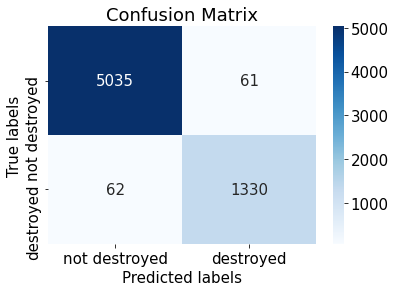

In [ ]:
# Plot Confusion Matrix in a slightly prettier format
ax= plt.subplot()
sns.heatmap(CF, annot=True, ax = ax, cmap='Blues', fmt='g'); #annot=True to annotate cells

# labels, title and ticks
plt.rc('font', size=15)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['not destroyed', 'destroyed']); ax.yaxis.set_ticklabels(['not destroyed', 'destroyed']);
plt.savefig('CM of Resnet (trained on xbd) on XbD Test Set.png')

In [ ]:
# Calculate and print accuracy, precision, recall, and F1 score
tp = CF[1,1]
tn = CF[0,0]
fp = CF[0,1]
fn = CF[1,0]
precision = tp / (tp + fp)
recall = tp / (tp + fn)
F1 = 2 * tp / (2*tp + fp + fn)
print('Accuracy: ', (CF[0,0] + CF[1,1]) / (CF[0,1] + CF[1,0] + CF[0,0] + CF[1,1]))
print('Precision: ', precision)
print('Recall: ', recall)
print('F1 Score: ', F1)

Accuracy:  0.9810419235511714
Precision:  0.9561466570812365
Recall:  0.9554597701149425
F1 Score:  0.955803090190442


Visualize some wrong predictions

In [ ]:
wrong_validation_examples = []  # a list in which we will append all of the images that were predicted wrong by the model (and their true labels)
dest1_pred_safe0 = []           # a list in which we will append all of the images depicting a destroyed building that were labeled as "undamaged"

for examples, true_labels in dataloaders_dict['test']:
  examples = examples.to(device)
  i += 1
  print('batch', i, '/', int(np.ceil(NUM_VAL / BATCH_SIZE)))

  with torch.no_grad():
    outputs = model(examples)
    _, preds = torch.max(outputs, 1)


  wrong_indices = np.nonzero(true_labels.numpy() - preds.data.cpu().numpy())

  for k in wrong_indices[0]:
    if int(true_labels[k]) == 1:
      print( (i-1)*BATCH_SIZE + 1 + k )
      dest1_pred_safe0.append((i-1)*BATCH_SIZE + 1 + k)

  wrong_validation_examples.append((examples.cpu().numpy()[wrong_indices] , true_labels.numpy()[wrong_indices]))


wrong_validation_examples_tuple = []
for ii in range(len(wrong_validation_examples)):
  for jj in range(len(wrong_validation_examples[ii][0])):
    wrong_validation_examples_tuple.append((wrong_validation_examples[ii][0][jj], wrong_validation_examples[ii][1][jj]))

The following cell will take the list with the images that were labelled erroneously and it will remove the transformations that were performed to these images in order to be given to the model (i.e. it will reconstruct the original image from the transformed version. We are doing that in order to print the real images in the following cell and see what makes the model classify an image incorrectly.

In [ ]:
to_pil = transforms.ToPILImage()
original_wrong_images = []   # this list will contain the original missclassified images
original_wrong_labels = []   # this list will contain the true labels of the original missclassified images

for i in range(len(wrong_validation_examples_tuple)):
    reconstructed_image = np.zeros((3, 224, 224))
    reconstructed_image[0, :, :] = wrong_validation_examples_tuple[i][0][0, :, :] * STD[0] + MEAN[0]
    reconstructed_image[1, :, :] = wrong_validation_examples_tuple[i][0][1, :, :] * STD[1] + MEAN[1]
    reconstructed_image[2, :, :] = wrong_validation_examples_tuple[i][0][2, :, :] * STD[2] + MEAN[2]
    original_wrong_images.append(to_pil(torch.tensor(np.float32(reconstructed_image))))
    original_wrong_labels.append(wrong_validation_examples_tuple[i][1])

print('total wrong examples: ',len(original_wrong_labels))

total wrong examples:  207


Get Some random wrong predictions and print them

In [ ]:
num_images_to_print = 6  # number of images to get and print
indices = list(range(len(wrong_validation_examples_tuple)))
np.random.shuffle(indices)
idx = indices[:num_images_to_print]
images_to_print = []
labels_to_print = []

for ii in range(len(idx)):
  images_to_print.append(original_wrong_images[idx[ii]])
  labels_to_print.append(original_wrong_labels[idx[ii]])

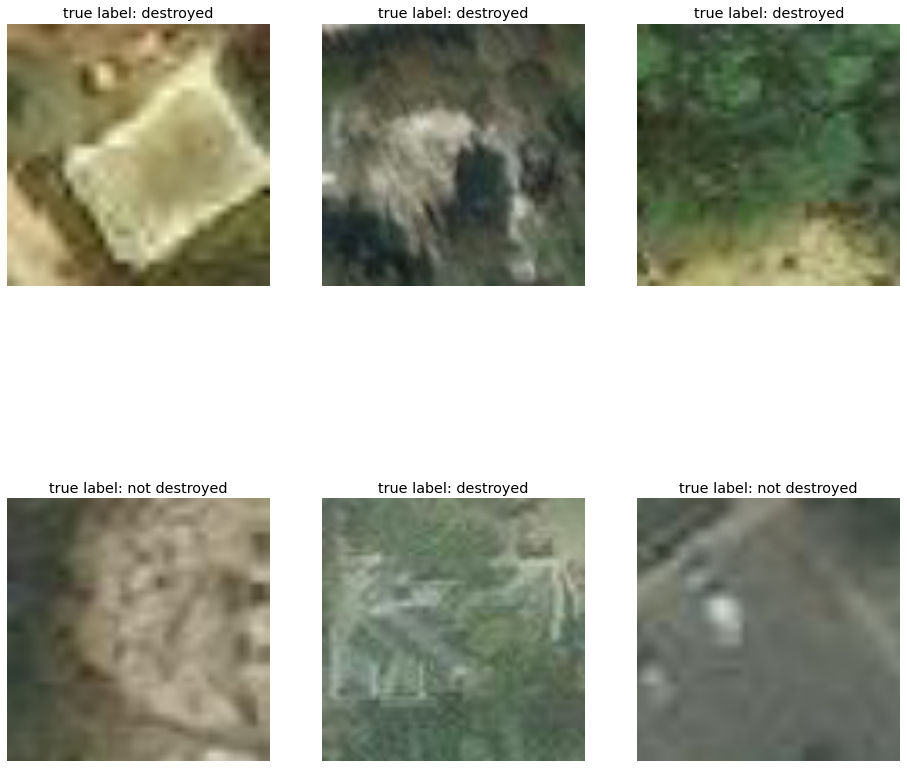

In [ ]:
fig=plt.figure(figsize=(16, 16))
classes = val_dataset.classes

for ii in range(num_images_to_print):
    image = images_to_print[ii]
    label = labels_to_print[ii]
    cor_class = classes[label]
    plt.rc('font', size=12)
    sub = fig.add_subplot(2, num_images_to_print/2, ii+1)
    if cor_class == classes[0]:
      sub.set_title( 'true label' + ': ' + str(cor_class.split('_')[1]) + " " + cor_class.split('_')[2])
    else:
      sub.set_title('true label' + ': ' + str(cor_class.split('_')[1]))
    plt.axis('off')
    plt.imshow(image)
    plt.savefig('damaged_structures_detector/Model Wrong Predictions.png')
plt.show()

The following cells will take the missclassified images printed above and they will print them again, together with their saliency maps.

In [ ]:
to_tens = transforms.ToTensor()
gpu_images, labels, classes = get_random_images(len(images_to_print))
labels = torch.tensor(labels_to_print, dtype=torch.int64)

for i in range(gpu_images.shape[0]):
    gpu_images[i,:,:,:] = test_transforms_predict(to_tens(images_to_print[i]))

# Compute Saliency Maps
saliency = compute_saliency_maps(gpu_images, labels, model)

labels = labels.cpu().numpy()

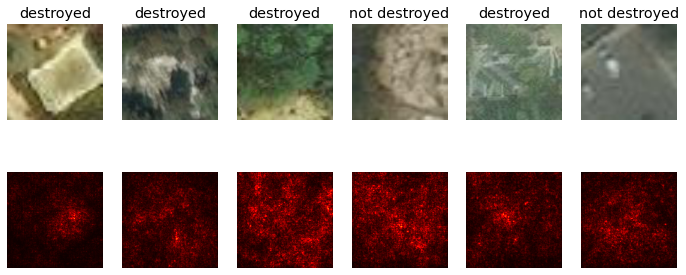

In [ ]:
N = len(images_to_print)
for i in range(N):

    image = images_to_print[i]
    plt.subplot(2, N, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.rc('font', size=12)
    if labels[i] == 0:
      plt.title('not destroyed')     
    else:
      plt.title('destroyed')
    plt.subplot(2, N, N + i + 1)
    plt.imshow(saliency[i], cmap=plt.cm.hot)
    plt.axis('off')
    plt.gcf().set_size_inches(12, 5)
    plt.savefig('damaged_structures_detector/Saliency Maps.png')
plt.show()

The following cells will print some random images after the addition of random noise described in the paper. That will help us visualize the effects of Random Noise on the images.

In [ ]:
FOLDERNAME = 'damaged_structures_detector/xbd_images'  # Path to the masterfolder. In our case this master folder contains subfolders corresponding to train, validation, and test set


data_transform = transforms.Compose([     # prepare the random noise transformation that we will apply to the images
        transforms.Resize(224),
        transforms.ColorJitter(brightness=0.8, contrast=0.6, saturation=0.3, hue=0),
        transforms.ToTensor(),
    ])

train_dataset = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'train'),transform = data_transform)
val_dataset = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'val'),transform = data_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'test'),transform = data_transform)

In [ ]:
loader_train = DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers = 16) ## switch "shuffle = True" if the user prefers that 

loader_val = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers = 16) 

loader_test = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers = 16)

Following function will pick a specified number of random images from the specified dataset (with random noise added)

In [ ]:
data = val_dataset # dataset from which the function will be picking random images

def get_random_images_wnoise(num):
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels, data.classes

Following cell is printing some random images to see the random noise effects

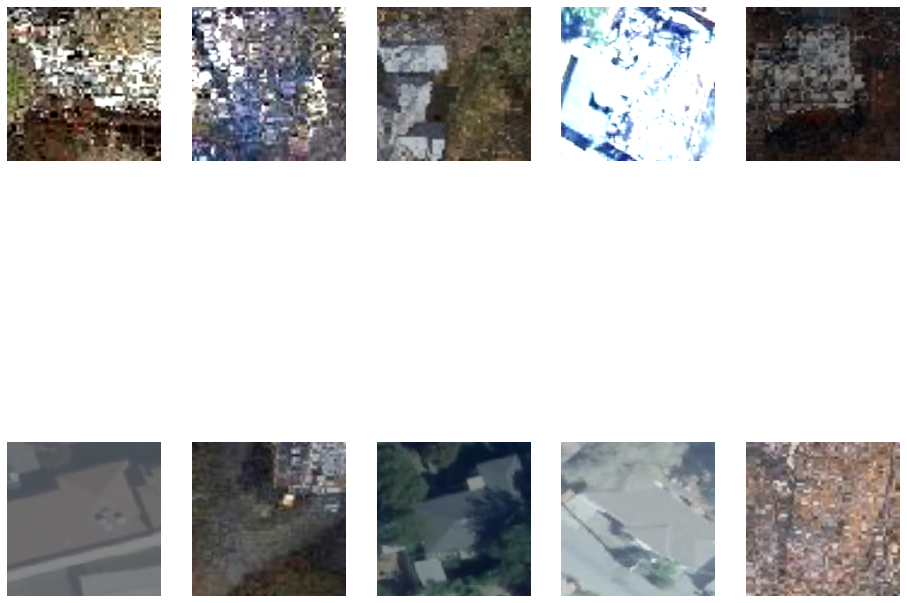

In [ ]:
to_pil = transforms.ToPILImage()
images, labels, classes = get_random_images_wnoise(10)
fig=plt.figure(figsize=(16, 16))

for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(2, len(images)/2, ii+1)
    fig.subplots_adjust(hspace=0.0, wspace=0.2)
    plt.axis('off')
    plt.imshow(image)
    #plt.savefig('Model Predictions.png')
plt.show()

The following cell is loading the RGB histograms from a given dataset and displays the normalized RGB distribution. This cell can only be used if the RGB histograms have already been calculated and stored. The code that calculates and stores them can be found in the training notebook.

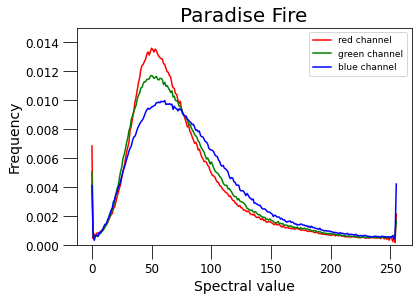

In [ ]:
red = np.load('damaged_structures_detector/paradise_red_hist.npy')
green = np.load('damaged_structures_detector/paradise_green_hist.npy')
blue = np.load('damaged_structures_detector/paradise_blue_hist.npy')
spectral_range = np.arange(256)
R = 0
G = 0
B = 0

for i in np.arange(255):
 R += (red[i][0] + red[i+1][0]) / 2
 G += (green[i][0] + green[i+1][0]) / 2
 B += (blue[i][0] + blue[i+1][0]) / 2

red   /= R
green /= G
blue  /= B

plt.figure()
plt.plot(spectral_range, red, 'r', spectral_range, green, 'g', spectral_range, blue, 'b' )
plt.ylim(0, 0.015)
plt.title("Paradise Fire", size=20)
plt.xlabel('Spectral value', size = 14)
plt.ylabel('Frequency', size = 14)
plt.tick_params(size = 14)
plt.legend(["red channel", "green channel", "blue channel"], fontsize = 9)
plt.show()